The goal of this challenge is to build a model that predicts conversion rate and, based on the model, come up with ideas to improve revenue.

In [266]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, balanced_accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier

In [2]:
# read data
conversion_data = pd.read_csv('/Users/kexinluo/Desktop/DS_take_home/1.conversion/conversion_data.csv')
conversion_data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


# Data exploratory analysis and visualization

In [3]:
print(conversion_data.info())
# check for any missing values
print('\n------------------------')
print('count of missing values of each column')
conversion_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB
None

------------------------
count of missing values of each column


country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

In [4]:
# summary statistics of each column
conversion_data.describe()
# max age is likely wrong, need to remove unrealistic ages

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [5]:
conversion_data[conversion_data['age'] > 90]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [6]:
conversion_data = conversion_data[conversion_data['age'] < 100]

In [7]:
# for each column, find count of unique values and print the top 5 unique values
for column in conversion_data.columns:
    uniques = sorted(conversion_data[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

country                  4	 ['China', 'Germany', 'UK', 'US']
age                     58	 [17, 18, 19, 20, 21]
new_user                 2	 [0, 1]
source                   3	 ['Ads', 'Direct', 'Seo']
total_pages_visited     29	 [1, 2, 3, 4, 5]
converted                2	 [0, 1]


In [8]:
# check proportion of each category in country, new_user, source and converted
print(conversion_data['country'].value_counts(normalize=True))
print('\n')
print(conversion_data['new_user'].value_counts(normalize=True))
print('\n')
print(conversion_data['source'].value_counts(normalize=True))

print(conversion_data['converted'].value_counts(normalize=True))

US         0.563229
China      0.242260
UK         0.153224
Germany    0.041287
Name: country, dtype: float64


1    0.685469
0    0.314531
Name: new_user, dtype: float64


Seo       0.490323
Ads       0.280644
Direct    0.229034
Name: source, dtype: float64


0    0.967748
1    0.032252
Name: converted, dtype: float64


The target value 'converted' is highly imbalanced

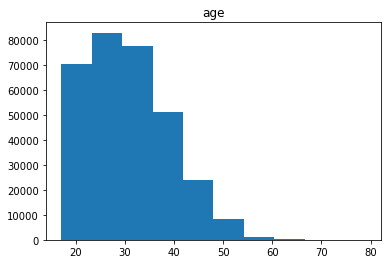

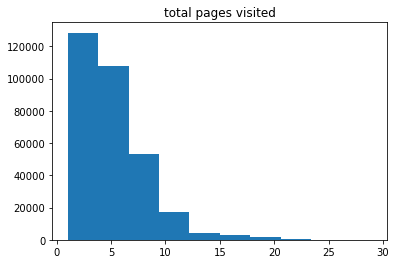

In [9]:
# visualize the distribution of the continues variables
plt.hist(conversion_data['age'])
plt.title("age")
plt.show()

plt.hist(conversion_data['total_pages_visited'])
plt.title("total pages visited")
plt.show()

   country  converted
0    China   0.001332
1  Germany   0.062428
2       UK   0.052612
3       US   0.037801


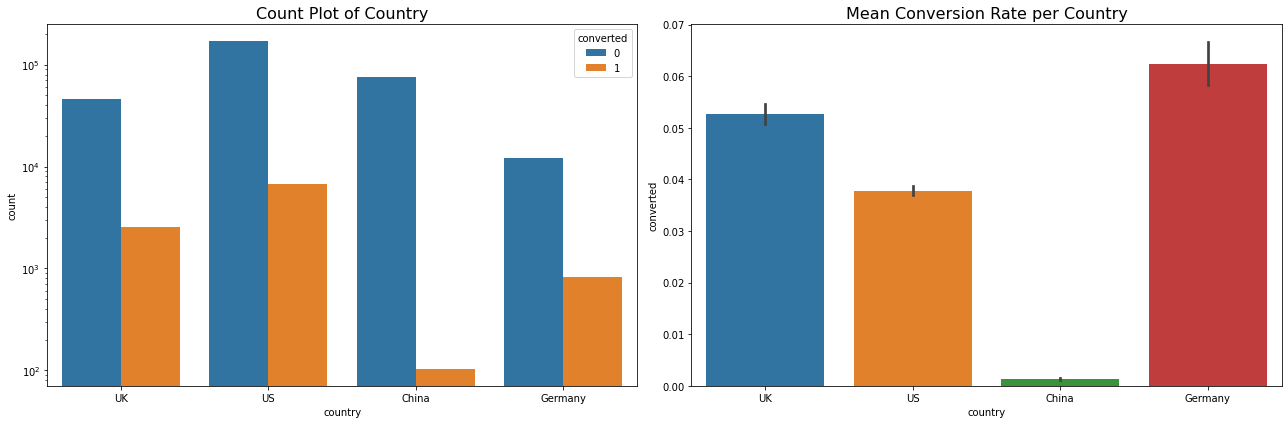

In [13]:
# Visualize conversion rate of different countries
grouped = conversion_data[['country', 'converted']].groupby('country').mean().reset_index()
print(grouped)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='country', hue='converted', data=conversion_data, ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='country', y='converted', data=conversion_data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Country', fontsize=16)
plt.tight_layout()
plt.show()

The variable 'country' has a great impact on convertion rate. Specifically, China has a very low convertion rate and Germany has the highest convertion rate, though the proportion of Germany is very low. 

   new_user  converted
0         0   0.071983
1         1   0.014021


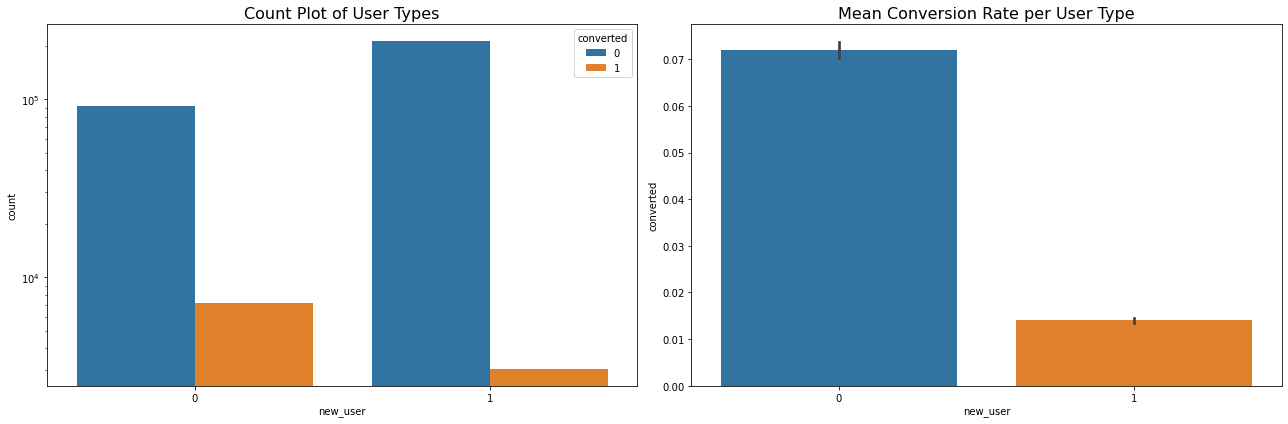

In [14]:
# Visualize conversion rate of different user types
grouped = conversion_data[['new_user', 'converted']].groupby('new_user').mean().reset_index()
print(grouped)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='new_user', hue='converted', data=conversion_data, ax=ax[0])
ax[0].set_title('Count Plot of User Types', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='new_user', y='converted', data=conversion_data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per User Type', fontsize=16)
plt.tight_layout()
plt.show()

New user seems to have a higher convertion rate than existing user.

   source  converted
0     Ads   0.034472
1  Direct   0.028169
2     Seo   0.032888


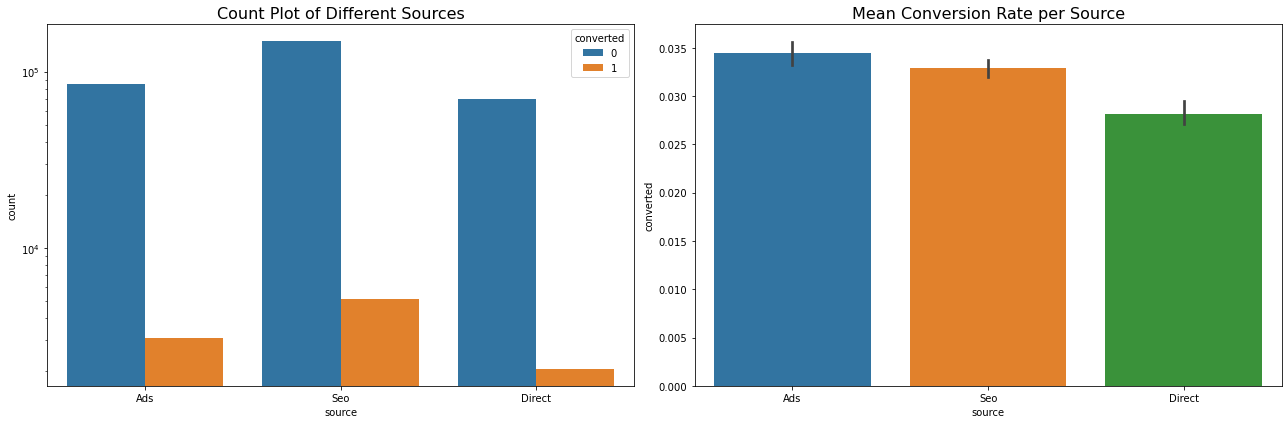

In [15]:
# Visualize conversion rate of different sources
grouped = conversion_data[['source', 'converted']].groupby('source').mean().reset_index()
print(grouped)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='source', hue='converted', data=conversion_data, ax=ax[0])
ax[0].set_title('Count Plot of Different Sources', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='source', y='converted', data=conversion_data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Source', fontsize=16)
plt.tight_layout()
plt.show()

The convertion rates over different marketing channels are very similar.

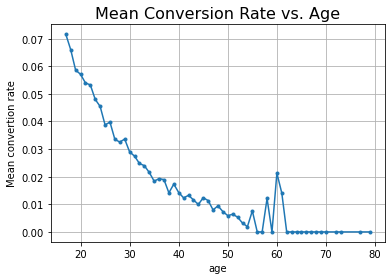

In [50]:
# Visualize conversion rate of age
grouped = conversion_data[['age', 'converted']].groupby('age').mean().reset_index()
plt.plot(grouped['age'], grouped['converted'], '.-')
plt.title('Mean Conversion Rate vs. Age', fontsize=16)
plt.xlabel('age')
plt.ylabel('Mean convertion rate')
plt.grid(True)
plt.show()

The mean convertion rate declines with age, but there are some peaks around 55 to 60. 

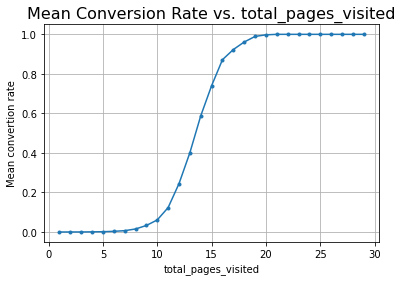

In [52]:
# Visualize conversion rate of total_pages_visited
grouped = conversion_data[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()
plt.plot(grouped['total_pages_visited'], grouped['converted'], '.-')
plt.title('Mean Conversion Rate vs. total_pages_visited', fontsize=16)
plt.xlabel('total_pages_visited')
plt.ylabel('Mean convertion rate')
plt.grid(True)
plt.show()

The mean convertion rate increases with total_pages_visited, but the trend is not linear.

# Data preprocessing

Encode categorical variables into one-hot encoding

In [80]:
# one-hot-encode using sklearn
conversion_data_encode = conversion_data.copy()

one_hot = OneHotEncoder()
encoded = one_hot.fit_transform(conversion_data[['country','source']])
conversion_data_encode[one_hot.categories_[0]] = encoded[:,0:4].toarray()
conversion_data_encode[one_hot.categories_[1]] = encoded[:,4:7].toarray()

conversion_data_encode.drop(['country','source'], axis=1, inplace=True)

conversion_data_encode.head()

,age,new_user,total_pages_visited,converted,China,Germany,UK,US,Ads,Direct,Seo
0,25,1,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,23,1,5,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,28,1,4,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,39,1,5,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,30,1,6,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [81]:
y = conversion_data_encode["converted"]
X = conversion_data_encode.drop(columns=["converted"])
X.head()

,age,new_user,total_pages_visited,China,Germany,UK,US,Ads,Direct,Seo
0,25,1,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,23,1,5,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,28,1,4,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,39,1,5,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,30,1,6,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

The response is highly imbalanced, so we can downsample the majority class or apply unequal weights in the model fitting to achieve some balance. 

In [92]:
print(f"number of converted samples in train: {sum(y_train == 1)} ({round(sum(y_train == 1)/sum(y_train == 0)*100,2)}%)")
print(f"number of unconverted samples in train: {sum(y_train == 0)}")

number of converted samples in train: 6881 (3.36%)
number of unconverted samples in train: 204971


In [94]:
# apply random forest with unequal class weights on the original data set
clf = RandomForestClassifier(max_depth=20, class_weight = 'balanced', n_estimators = 100)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20)

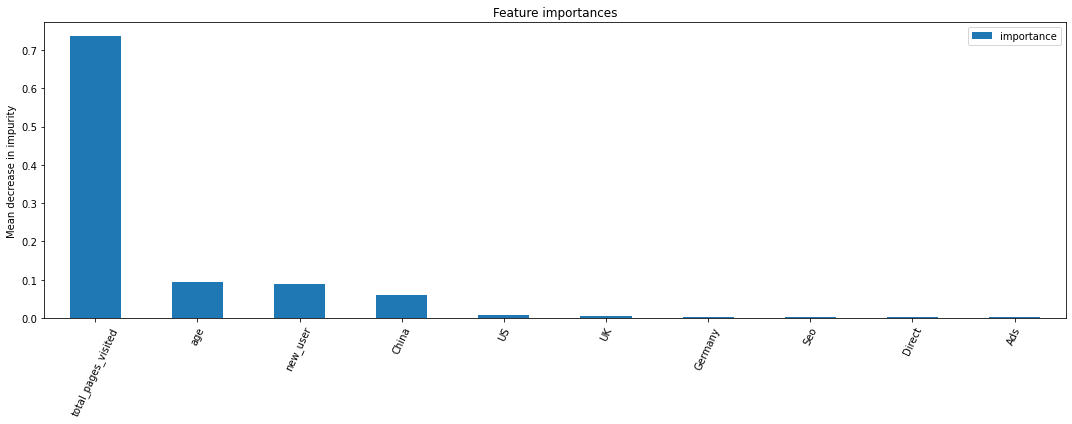

In [95]:
# feature importance plot
importances = clf.feature_importances_
feature_names = X_train.columns.values.tolist()
d = {'importance':importances, 'feature': feature_names}
forest_importances = pd.DataFrame(data=d)
forest_importances.sort_values(by=['importance'],ascending = False,inplace=True)
forest_importances_plt = forest_importances.head(15)

fig, ax = plt.subplots(figsize=(15, 6))
forest_importances_plt.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(forest_importances_plt['feature'],rotation=65)
fig.tight_layout()

In [133]:
# Predict on test data
test_prediction = clf.predict(X_test)
confusion_matrix(y_test, test_prediction)

array([[97629,  3400],
       [  553,  2764]])

In [136]:
print(f"recall: {recall_score(y_test, test_prediction, average='binary'):.3f}")
print(f"precision: {precision_score(y_test, test_prediction, average='binary'):.3f}")
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_prediction, pos_label=1)
print(f"AUC: {metrics.auc(fpr, tpr):.3f}")
print(f"balanced accuracy: {balanced_accuracy_score(y_test, test_prediction):.3f}")

recall: 0.833
precision: 0.448
AUC: 0.900
balanced accuracy: 0.900


In [124]:
# down sample unconverted data to create a slightly balanced dataset
X = pd.concat([X_train, y_train], axis=1)
undersample = pd.concat([X[X['converted']==1], 
                         X[X['converted']==0].sample(frac=0.1, random_state=42)])

# now randomly shuffle the dataframe rows in order to mix up the classes again
undersample = undersample.sample(frac=1, random_state=42)
print(undersample['converted'].value_counts(normalize=True))
print(undersample.shape[0])

0    0.748667
1    0.251333
Name: converted, dtype: float64
27378


In [125]:
y_train_b = undersample["converted"]
X_train_b = undersample.drop(columns=["converted"])
X_train_b.head()

,age,new_user,total_pages_visited,China,Germany,UK,US,Ads,Direct,Seo
301014,32,1,6,1.0,0.0,0.0,0.0,1.0,0.0,0.0
284276,17,0,5,0.0,0.0,0.0,1.0,1.0,0.0,0.0
272786,35,1,6,0.0,0.0,0.0,1.0,0.0,1.0,0.0
30118,32,1,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0
313985,34,0,8,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [126]:
# apply random forest with unequal class weights on the original data set
clf_b = RandomForestClassifier(max_depth=20, class_weight = 'balanced', n_estimators = 100)
clf_b.fit(X_train_b, y_train_b)

RandomForestClassifier(class_weight='balanced', max_depth=20)

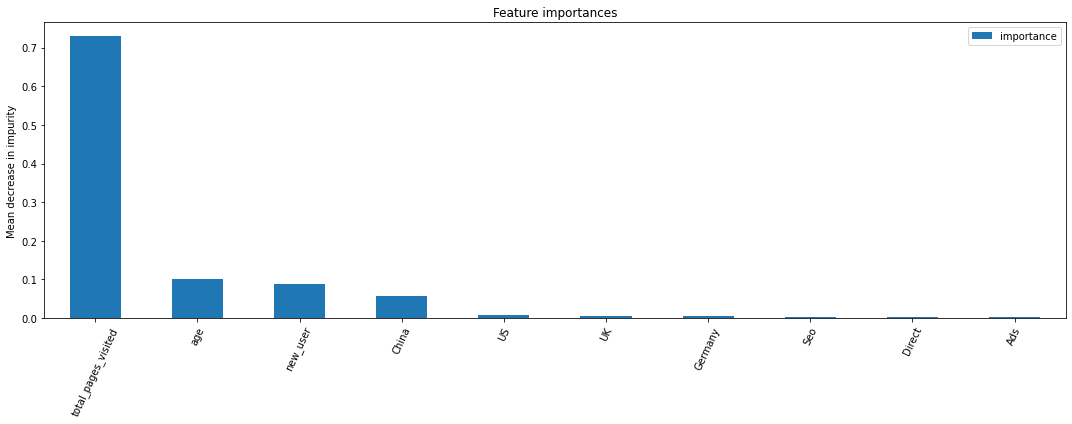

In [127]:
# feature importance plot
importances = clf_b.feature_importances_
feature_names = X_train_b.columns.values.tolist()
d = {'importance':importances, 'feature': feature_names}
forest_importances = pd.DataFrame(data=d)
forest_importances.sort_values(by=['importance'],ascending = False,inplace=True)
forest_importances_plt = forest_importances.head(15)

fig, ax = plt.subplots(figsize=(15, 6))
forest_importances_plt.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(forest_importances_plt['feature'],rotation=65)
fig.tight_layout()

In [137]:
# Predict on test data
test_prediction_b = clf_b.predict(X_test)
print(confusion_matrix(y_test, test_prediction_b))
print(f"recall: {recall_score(y_test, test_prediction_b, average='binary'):.3f}")
print(f"precision: {precision_score(y_test, test_prediction_b, average='binary'):.3f}")
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_prediction_b, pos_label=1)
print(f"AUC: {metrics.auc(fpr, tpr):.3f}")
print(f"balanced accuracy: {balanced_accuracy_score(y_test, test_prediction_b):.3f}")

[[96198  4831]
 [  371  2946]]
recall: 0.888
precision: 0.379
AUC: 0.920
balanced accuracy: 0.920


Down sampling could increase the classification performance on the minority class (recall and balanced accuracy increase)

# Pipeline data processing and classification and compare multiple methods

In this section I will repeat the data processing and modelling step but with a pipeline and compare multiple methods. I will use cross-validation to evaluate the model performance.

In [141]:
y = conversion_data["converted"]
X = conversion_data.drop(columns=["converted"])
X.head()

,country,age,new_user,source,total_pages_visited
0,UK,25,1,Ads,1
1,US,23,1,Seo,5
2,US,28,1,Seo,4
3,China,39,1,Seo,5
4,US,30,1,Seo,6


In [234]:
# create a table to record performance of different models
index = []
scores = {"Accuracy": [], "Balanced accuracy": [], "F1": [], "Precision": [], "Recall": [], "ROC AUC": []}

## Dummy classifier

In [235]:
# first use a majority vote classifier as a baseline
dummy_clf = DummyClassifier(strategy="most_frequent")
scoring = ["accuracy", "balanced_accuracy", "f1", "precision", "recall", "roc_auc"]

In [236]:
index += ["Dummy classifier"]
cv_result = cross_validate(dummy_clf, X, y, scoring=scoring)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision 

In [237]:
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores["F1"].append(cv_result["test_f1"].mean())
scores["Precision"].append(cv_result["test_precision"].mean())
scores["Recall"].append(cv_result["test_recall"].mean())
scores["ROC AUC"].append(cv_result["test_roc_auc"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy,F1,Precision,Recall,ROC AUC
Dummy classifier,0.967748,0.5,0.0,0.0,0.0,0.5


## Linear classifier

Use a logistic regression model, need to one-hot encode the categorical columns and standardized the numerical columns

In [238]:
cat_cols = ['country','source']
num_cols = ['age','total_pages_visited']
passthrough_cols = ['new_user']

In [239]:
preprocessor_linear = make_column_transformer(
    (StandardScaler(), num_cols),
    (OneHotEncoder(), cat_cols),
    ("passthrough", passthrough_cols), 
    n_jobs=2,
)

In [240]:
lr_clf = make_pipeline(preprocessor_linear, LogisticRegression(max_iter=1000))
cv_result = cross_validate(lr_clf, X, y, scoring=scoring)

In [241]:
index += ["Logistic regression"]
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores["F1"].append(cv_result["test_f1"].mean())
scores["Precision"].append(cv_result["test_precision"].mean())
scores["Recall"].append(cv_result["test_recall"].mean())
scores["ROC AUC"].append(cv_result["test_roc_auc"].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy,F1,Precision,Recall,ROC AUC
Dummy classifier,0.967748,0.500000,0.00000,0.000000,0.00000,0.500000
Logistic regression,0.986167,0.841994,0.76233,0.854876,0.68788,0.986027


## Random forest

In [242]:
# num_pipe = SimpleImputer(strategy="mean", add_indicator=True)

preprocessor_rf = make_column_transformer(
    ("passthrough", num_cols), 
    (OneHotEncoder(), cat_cols),
    ("passthrough", passthrough_cols), 
)

rf_clf = make_pipeline(
    preprocessor_rf, RandomForestClassifier(random_state=42, max_depth=20, n_estimators = 100)
)

In [244]:
cv_result = cross_validate(rf_clf, X, y, scoring=scoring)

In [246]:
index += ["Random forest"]
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores["F1"].append(cv_result["test_f1"].mean())
scores["Precision"].append(cv_result["test_precision"].mean())
scores["Recall"].append(cv_result["test_recall"].mean())
scores["ROC AUC"].append(cv_result["test_roc_auc"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy,F1,Precision,Recall,ROC AUC
Dummy classifier,0.967748,0.500000,0.000000,0.000000,0.000000,0.500000
Logistic regression,0.986167,0.841994,0.762330,0.854876,0.687880,0.986027
Random forest,0.984532,0.835889,0.738402,0.812141,0.676997,0.951846


## Logistic regression and Random Forest with class weight

In [247]:
lr_clf.set_params(logisticregression__class_weight="balanced")
cv_result = cross_validate(lr_clf, X, y, scoring=scoring)

In [258]:
index += ["Logistic regression with balanced class weights"]
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores["F1"].append(cv_result["test_f1"].mean())
scores["Precision"].append(cv_result["test_precision"].mean())
scores["Recall"].append(cv_result["test_recall"].mean())
scores["ROC AUC"].append(cv_result["test_roc_auc"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy,F1,Precision,Recall,ROC AUC
Dummy classifier,0.967748,0.500000,0.000000,0.000000,0.000000,0.500000
Logistic regression,0.986167,0.841994,0.762330,0.854876,0.687880,0.986027
Random forest,0.984532,0.835889,0.738402,0.812141,0.676997,0.951846
Logistic regression with balanced class weights,0.941692,0.940063,0.509357,0.349563,0.938322,0.986021


In [259]:
rf_clf.set_params(randomforestclassifier__class_weight="balanced")
cv_result = cross_validate(rf_clf, X, y, scoring=scoring)

In [260]:
index += ["Random forest with balanced class weights"]
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores["F1"].append(cv_result["test_f1"].mean())
scores["Precision"].append(cv_result["test_precision"].mean())
scores["Recall"].append(cv_result["test_recall"].mean())
scores["ROC AUC"].append(cv_result["test_roc_auc"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy,F1,Precision,Recall,ROC AUC
Dummy classifier,0.967748,0.500000,0.000000,0.000000,0.000000,0.500000
Logistic regression,0.986167,0.841994,0.762330,0.854876,0.687880,0.986027
Random forest,0.984532,0.835889,0.738402,0.812141,0.676997,0.951846
Logistic regression with balanced class weights,0.941692,0.940063,0.509357,0.349563,0.938322,0.986021
Random forest with balanced class weights,0.958943,0.900680,0.568472,0.430067,0.838399,0.948388


## Under sample the majority class during learning

In [262]:
lr_clf = make_pipeline_with_sampler(
    preprocessor_linear,
    RandomUnderSampler(random_state=42),
    LogisticRegression(max_iter=1000),
)

In [263]:
cv_result = cross_validate(lr_clf, X, y, scoring=scoring)
index += ["Under-sampling + Logistic regression"]

scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores["F1"].append(cv_result["test_f1"].mean())
scores["Precision"].append(cv_result["test_precision"].mean())
scores["Recall"].append(cv_result["test_recall"].mean())
scores["ROC AUC"].append(cv_result["test_roc_auc"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy,F1,Precision,Recall,ROC AUC
Dummy classifier,0.967748,0.500000,0.000000,0.000000,0.000000,0.500000
Logistic regression,0.986167,0.841994,0.762330,0.854876,0.687880,0.986027
Random forest,0.984532,0.835889,0.738402,0.812141,0.676997,0.951846
Logistic regression with balanced class weights,0.941692,0.940063,0.509357,0.349563,0.938322,0.986021
Random forest with balanced class weights,0.958943,0.900680,0.568472,0.430067,0.838399,0.948388
Under-sampling + Logistic regression,0.940521,0.940359,0.504930,0.345168,0.940185,0.985998


In [264]:
rf_clf = make_pipeline_with_sampler(
    preprocessor_rf,
    RandomUnderSampler(random_state=42),
    RandomForestClassifier(random_state=42, max_depth=20, n_estimators = 100),
)

In [265]:
cv_result = cross_validate(rf_clf, X, y, scoring=scoring)

index += ["Under-sampling + Random forest"]
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores["F1"].append(cv_result["test_f1"].mean())
scores["Precision"].append(cv_result["test_precision"].mean())
scores["Recall"].append(cv_result["test_recall"].mean())
scores["ROC AUC"].append(cv_result["test_roc_auc"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy,F1,Precision,Recall,ROC AUC
Dummy classifier,0.967748,0.500000,0.000000,0.000000,0.000000,0.500000
Logistic regression,0.986167,0.841994,0.762330,0.854876,0.687880,0.986027
Random forest,0.984532,0.835889,0.738402,0.812141,0.676997,0.951846
Logistic regression with balanced class weights,0.941692,0.940063,0.509357,0.349563,0.938322,0.986021
Random forest with balanced class weights,0.958943,0.900680,0.568472,0.430067,0.838399,0.948388
Under-sampling + Logistic regression,0.940521,0.940359,0.504930,0.345168,0.940185,0.985998
Under-sampling + Random forest,0.928048,0.927136,0.453654,0.300407,0.926161,0.974038


# Use of specific balanced algorithms from imbalanced-learn

Instead of under-sampling once the dataset, one could under-sample the original dataset before to take a bootstrap sample.

In [267]:
rf_clf = make_pipeline(
    preprocessor_rf,
    BalancedRandomForestClassifier(random_state=42, max_depth=20, n_estimators = 100),
)

In [268]:
cv_result = cross_validate(rf_clf, X, y, scoring=scoring)

index += ["Balanced random forest"]
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores["F1"].append(cv_result["test_f1"].mean())
scores["Precision"].append(cv_result["test_precision"].mean())
scores["Recall"].append(cv_result["test_recall"].mean())
scores["ROC AUC"].append(cv_result["test_roc_auc"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy,F1,Precision,Recall,ROC AUC
Dummy classifier,0.967748,0.500000,0.000000,0.000000,0.000000,0.500000
Logistic regression,0.986167,0.841994,0.762330,0.854876,0.687880,0.986027
Random forest,0.984532,0.835889,0.738402,0.812141,0.676997,0.951846
Logistic regression with balanced class weights,0.941692,0.940063,0.509357,0.349563,0.938322,0.986021
Random forest with balanced class weights,0.958943,0.900680,0.568472,0.430067,0.838399,0.948388
Under-sampling + Logistic regression,0.940521,0.940359,0.504930,0.345168,0.940185,0.985998
Under-sampling + Random forest,0.928048,0.927136,0.453654,0.300407,0.926161,0.974038
Balanced random forest,0.927248,0.931984,0.453800,0.299402,0.937047,0.980436
